# Data Visualisation
## 1. Data production park the Netherlands

Getting the data from multiple production parks in the Netherlands and cleaning this up and visualizing trends

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose

In [125]:
prodNL = pd.read_parquet('production.parquet', engine='pyarrow')
metadata = pd.read_csv("installations Netherlands.csv", sep=';')
metadata = metadata.set_index('id')
metadata.head(10)

,Watt Peak,Azimuth,Orientation,Tilt,ZIP_NL,Plaats,Latitude,Longitude
id,,,,,,,,
1183SB10,2480,113,-67,35,1183,Amstelveen,52.30864,4.88959
1183RW15,2480,202,22,35,1183,Amstelveen,52.30864,4.88959
1185PS233,1240,180,0,13,1185,Amstelveen,52.29065,4.85156
1791AW12,1240,90,-90,10,1791,Den Burg,53.05392,4.79605
1791AW12B,1240,90,-90,10,1791,Den Burg,53.05392,4.79605
2645JE56,2170,160,-20,25,2645,Delfgauw,52.00861,4.39657
2678WH10,2440,248,68,45,2678,De Lier,51.97790,4.25496
2678WG17,2440,115,-65,45,2678,De Lier,51.97790,4.25496
2678WH4,2440,248,68,45,2678,De Lier,51.97790,4.25496


In [126]:
prodNL.head(10)

watt
id       timestamp                
1183RW15 2019-08-27 13:45:00   0.0
         2019-08-27 14:00:00   0.0
         2019-08-27 14:15:00   0.0
         2019-08-27 14:30:00   0.0
         2019-08-27 14:45:00   0.0
         2019-08-27 15:00:00   0.0
         2019-08-27 15:15:00   0.0
         2019-08-27 15:30:00   0.0
         2019-08-27 15:45:00   0.0
         2019-08-27 16:00:00   0.0

In [127]:
#Check if there are NaN values or missing datetimes
print(prodNL.isnull().values.any())
for unique_id, installation_prod in prodNL.groupby(level=0):
    installation_prod.index = installation_prod.index.droplevel(0)
    start = installation_prod.index.min()
    end = installation_prod.index.max()
    metadata.loc[unique_id, "start"] = start
    metadata.loc[unique_id, "end"] = end
    expected_timestamps = pd.date_range(start=start, end=end, freq='15T')  # Assuming data is recorded every 15 minutes
    
    missing_timestamps = expected_timestamps[~expected_timestamps.isin(installation_prod.index)]
    
    if not missing_timestamps.empty:
        print(f"ID: {unique_id}, Missing Timestamps: {missing_timestamps}")
    else:
        print(f"ID: {unique_id}, No missing chronological data.")


    #Check if there are values above peak power
    peak_power = metadata.at[unique_id, 'Watt Peak']
    print(installation_prod[['watt']].gt(peak_power).any(axis=1).sum())

#Check if there are values smaller than 0
prodNL[["watt"]].lt(0).any(axis=1).sum()

False
ID: 1183RW15, No missing chronological data.
0
ID: 1183SB10, No missing chronological data.
0
ID: 1185PS233, No missing chronological data.
0
ID: 1791AW12, No missing chronological data.
0
ID: 1791AW12B, No missing chronological data.
0
ID: 2645JE56, No missing chronological data.
0
ID: 2678WG17, No missing chronological data.
0
ID: 2678WH10, No missing chronological data.
0
ID: 2678WH4, No missing chronological data.
0
ID: 2993AM21, No missing chronological data.
0
ID: 2993AP7, No missing chronological data.
0
ID: 3343EH47, No missing chronological data.
0
ID: 3343EH67, No missing chronological data.
0
ID: 3437BD60, No missing chronological data.
0
ID: 3551XT40, No missing chronological data.
0
ID: 3705PN116, No missing chronological data.
0
ID: 3994TC15, No missing chronological data.
0
ID: 4131AE11, No missing chronological data.
0
ID: 4131CC21, No missing chronological data.
0
ID: 4251BW7, No missing chronological data.
0
ID: 4891XX2, No missing chronological data.
0
ID: 4901

0

### Plotting

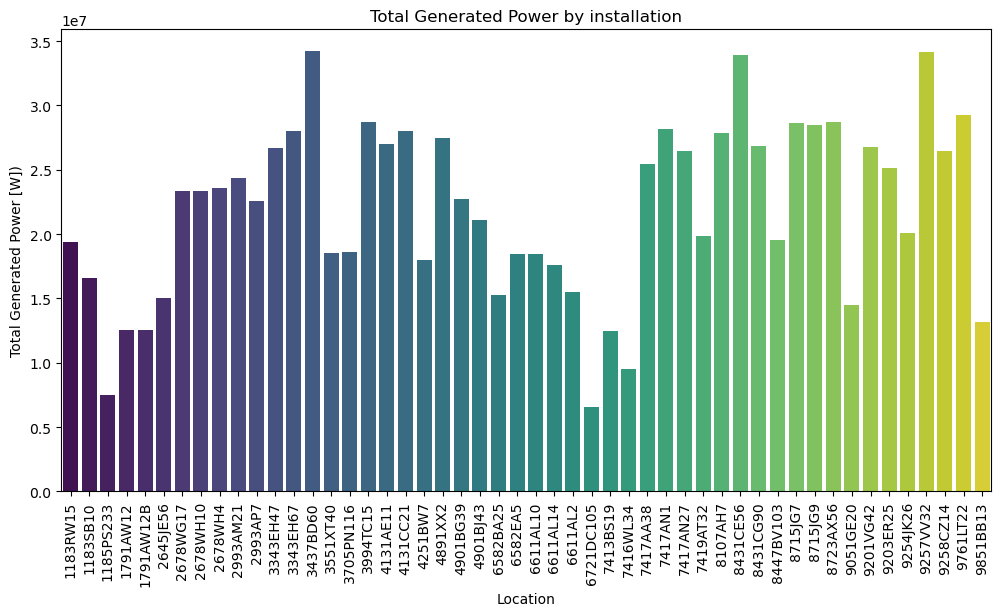

In [128]:
installation_power = prodNL.groupby('id')['watt'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='id', y='watt', data=installation_power, palette='viridis')
plt.title('Total Generated Power by installation')
plt.xlabel('Location')
plt.ylabel('Total Generated Power [W])')
plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical
plt.show()

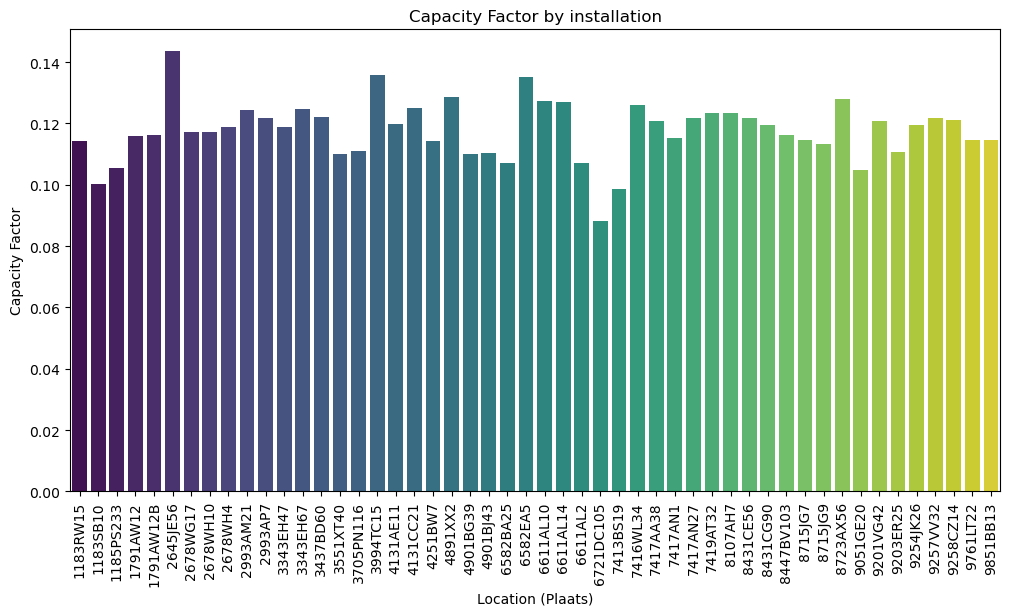

In [129]:

#
nb_of_days = (metadata.end-metadata.start).dt.days
nb_of_days.head()
installation_power.set_index('id', inplace= True, drop = True)
installation_power["nb_days"] = nb_of_days
installation_power["Watt Peak"] = metadata['Watt Peak']
installation_power["cf"] = installation_power['watt']/(24*4*installation_power["nb_days"]*installation_power['Watt Peak'])

# Create a bar graph for capacity factor using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=installation_power.index, y='cf', data=installation_power, palette='viridis')
plt.title('Capacity Factor by installation')
plt.xlabel('Location (Plaats)')
plt.ylabel('Capacity Factor')
plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical
plt.show()

In [140]:
ID_selection = ('2645JE56', '6721DC105', '1183RW15', '3437BD60', '9851BB13')
for unique_id in ID_selection:
    installation_prod = prodNL.loc[(unique_id,)]
    
    print(installation_prod)



                     watt
timestamp                
2019-08-27 13:45:00   0.0
2019-08-27 14:00:00   0.0
2019-08-27 14:15:00   0.0
2019-08-27 14:30:00   0.0
2019-08-27 14:45:00   0.0
...                   ...
2021-08-09 19:30:00   0.0
2021-08-09 19:45:00   0.0
2021-08-09 20:00:00   0.0
2021-08-09 20:15:00   0.0
2021-08-09 20:30:00   0.0

[68476 rows x 1 columns]
                       watt
timestamp                  
2020-03-25 12:15:00  1680.0
2020-03-25 12:30:00  1680.0
2020-03-25 12:45:00  1680.0
2020-03-25 13:00:00  1640.0
2020-03-25 13:15:00  1600.0
...                     ...
2021-08-09 19:30:00     0.0
2021-08-09 19:45:00     0.0
2021-08-09 20:00:00     0.0
2021-08-09 20:15:00     0.0
2021-08-09 20:30:00     0.0

[48226 rows x 1 columns]
                     watt
timestamp                
2020-06-18 13:45:00   0.0
2020-06-18 14:00:00   0.0
2020-06-18 14:15:00   0.0
2020-06-18 14:30:00   0.0
2020-06-18 14:45:00   0.0
...                   ...
2021-08-09 19:30:00   0.0
2021-08-09 1

KeyError: '3437DB60'

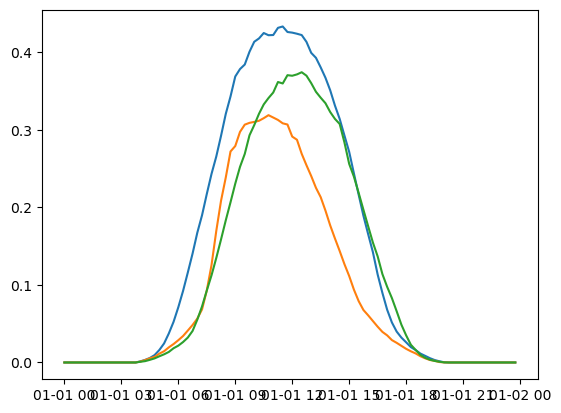

In [141]:
#Select some ID's of diverse locations in terms of total generated power and CF
ID_selection = ('2645JE56', '6721DC105', '1183RW15', '3437BD60', '9851BB13')

#Plot average daily generation profile for each location
for unique_id in ID_selection:
    installation_prod = prodNL.loc[(unique_id,)]
    peak_power = metadata.at[unique_id, 'Watt Peak']
    installation_prod['hour'] = installation_prod.index.hour
    installation_prod['minute'] = installation_prod.index.minute
    daily_profile = installation_prod.groupby(['hour', 'minute']).mean()/peak_power
    # Create a bar graph for capacity factor using seaborn
    daily_profile.index = pd.to_datetime(daily_profile.index.map(lambda x: f'{x[0]:02d}:{x[1]:02d}'), format='%H:%M')
    # Setting 'Time' as the DateTime index
    plt.plot(daily_profile)

watt
id       timestamp                
1183RW15 2019-08-27 13:45:00   0.0
         2019-08-27 14:00:00   0.0
         2019-08-27 14:15:00   0.0
         2019-08-27 14:30:00   0.0
         2019-08-27 14:45:00   0.0
...                            ...
9851BB13 2021-08-09 19:30:00   0.0
         2021-08-09 19:45:00   0.0
         2021-08-09 20:00:00   0.0
         2021-08-09 20:15:00   0.0
         2021-08-09 20:30:00   0.0

[3976408 rows x 1 columns]

## Random

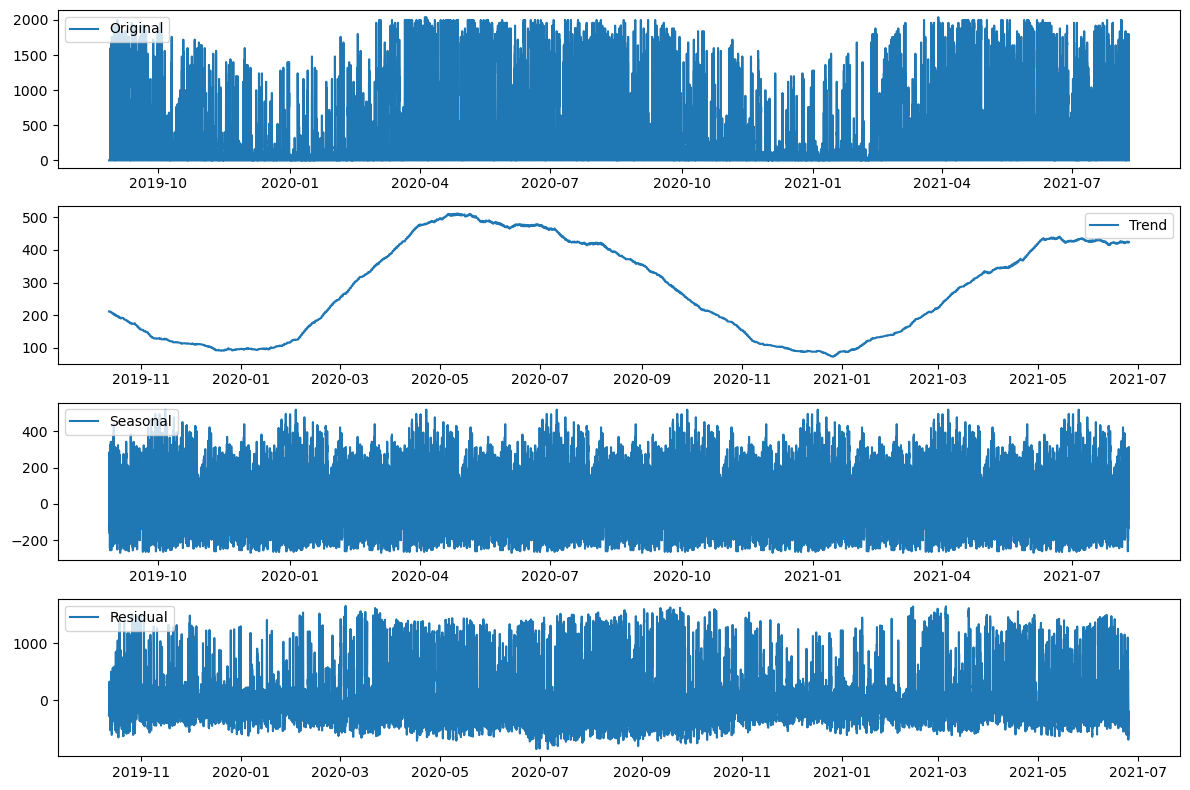

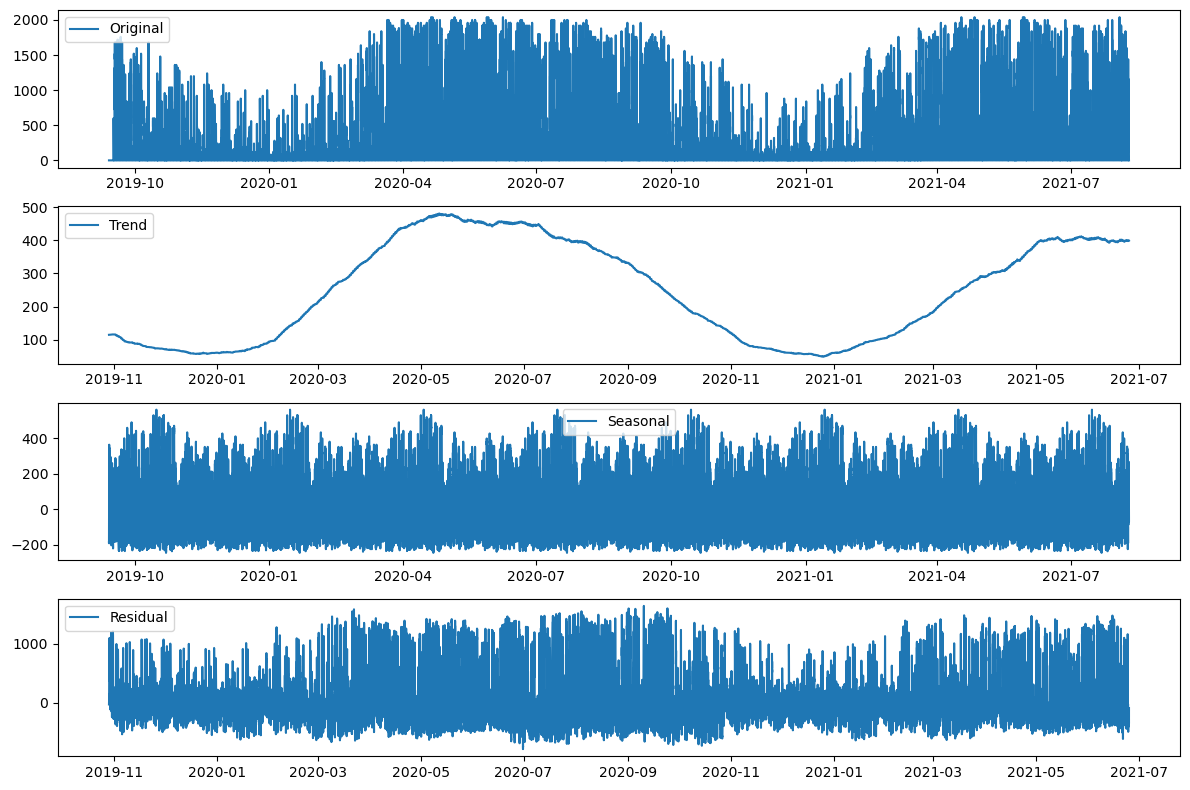

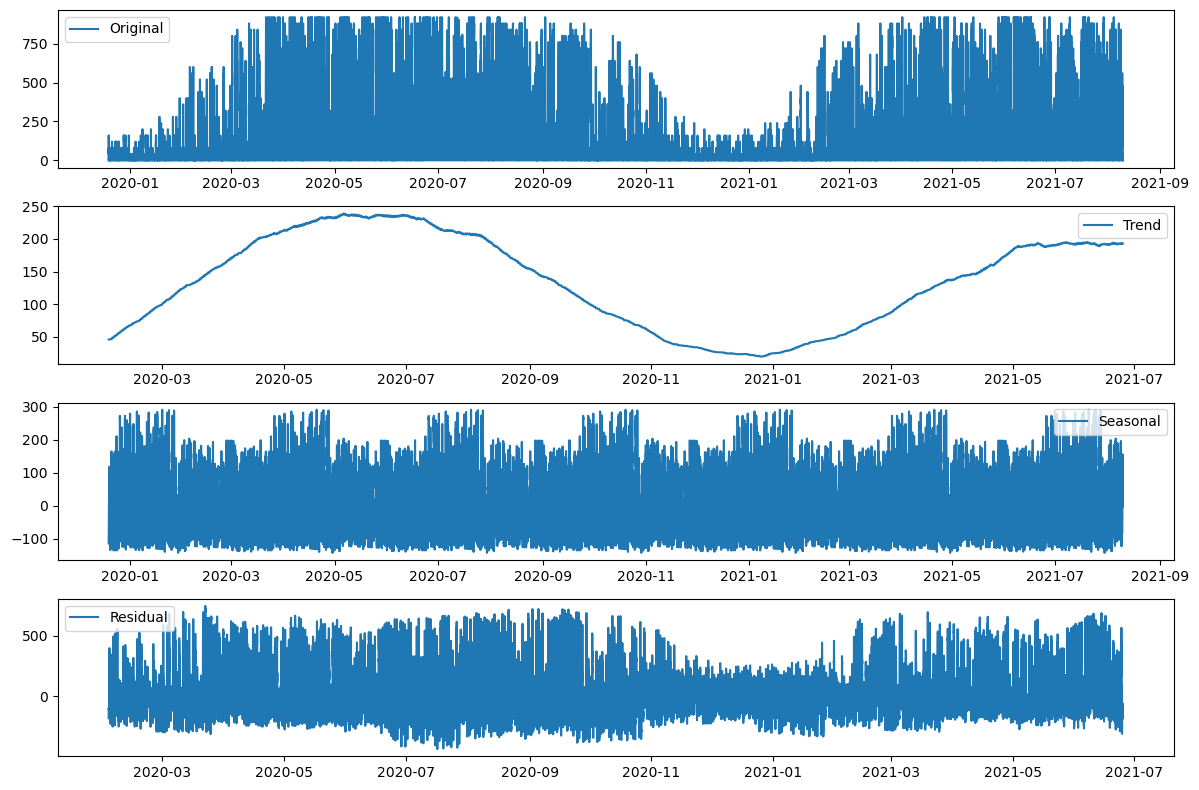

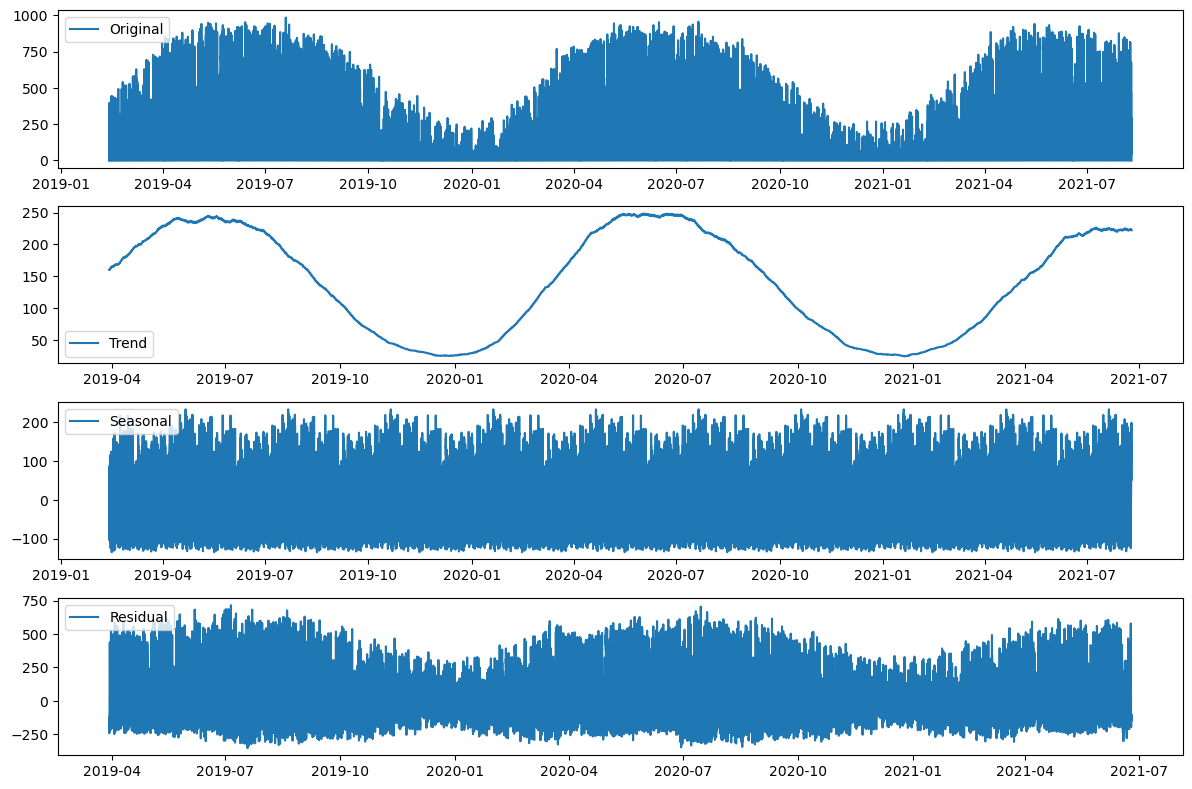

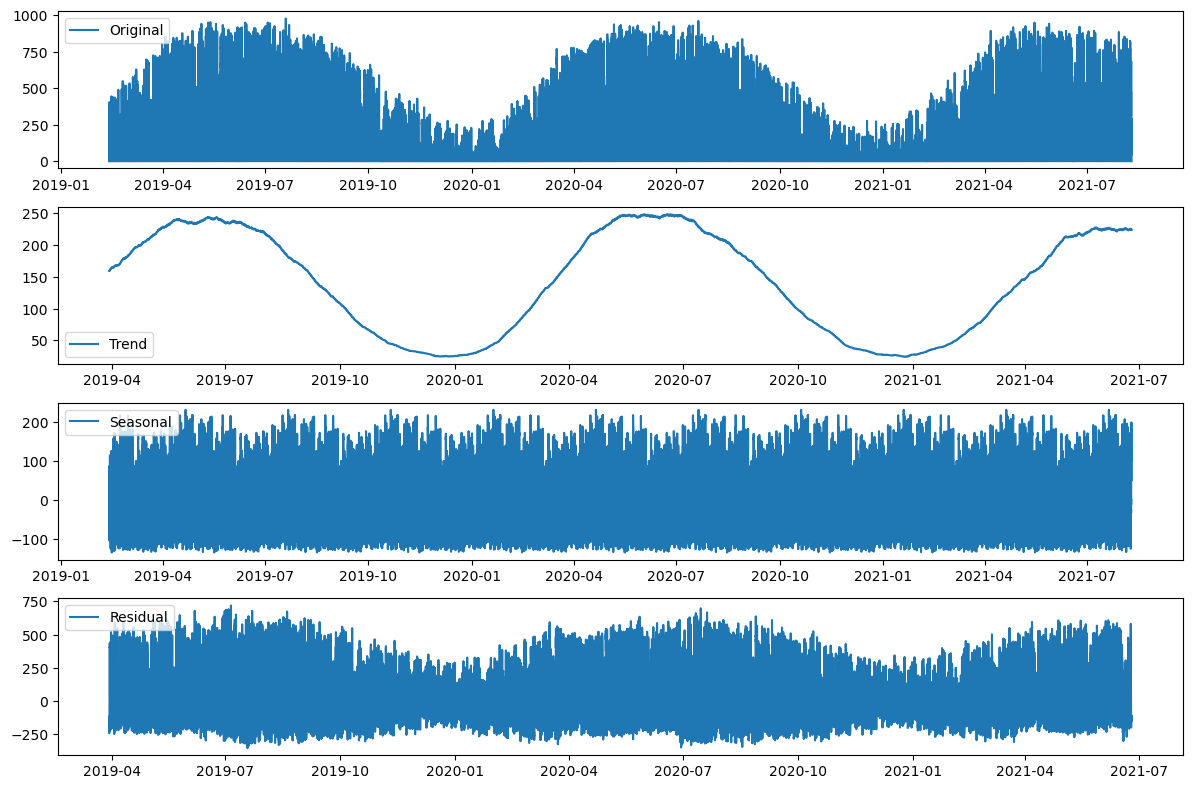

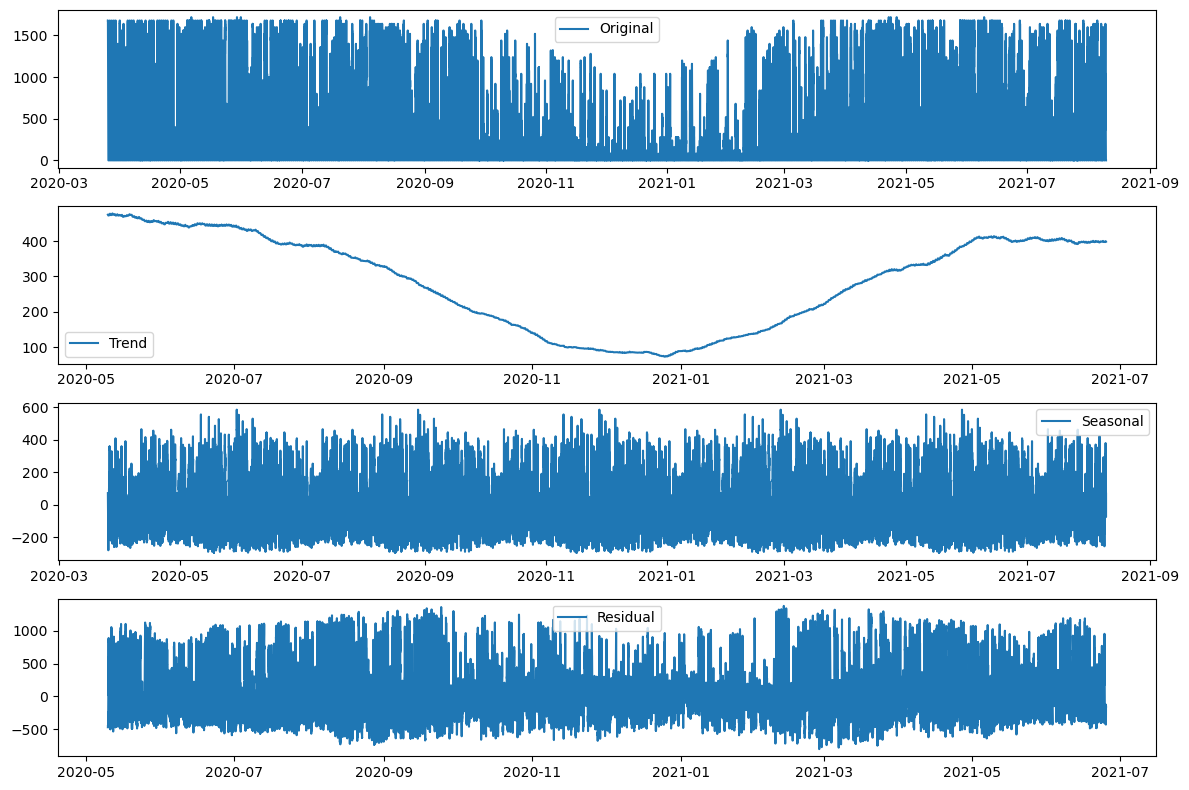

KeyboardInterrupt: 

In [131]:
#Playing around with seasonal decomposition
for unique_id, installation_prod in prodNL.groupby(level=0):
    installation_prod = installation_prod.droplevel(0)
    result = seasonal_decompose(installation_prod['watt'], model='additive', period=24*365)
    # Plot the decomposition results
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(installation_prod['watt'], label='Original')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()
